#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


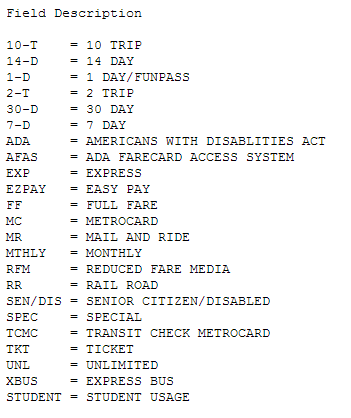

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import pylab as pl
import os
import json
import urllib2
from zipfile import ZipFile
from StringIO import StringIO
import statsmodels.api as sm
from scipy import stats
from matplotlib.font_manager import FontProperties
%pylab inline

s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/Users/Daynan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
# axis 0 = subway stations (600)
# axis 1 = rider type (23, listed above)
# axis 2 = count per week (194)
print mta.shape

(600, 23, 194)


In [4]:
# convert to float and convert -1 to NaN
mta = mta.astype(float)
mta[mta == -1] = NaN

In [5]:
# create a range of weeks
myweeks = pd.date_range(start = '2010-05-21', periods = 194, freq = 'W')

Note the range of 194 weeks from May 21 ends on Feb 2, 2014...not Feb 21 as stated. Either the stated date range is wrong (even with an offset week that begins Sunday 5/23 and not 5/21, the date range is still a couple weeks short). Or there are missing weeks in the MTA data and not possible to identify which weeks. I'll work under the assumption that no weeks are missing and the end week is really Feb 2, not Feb 21.

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.

####DJC - First, we'll sum all stations for the first rider type (10-Trip) and examine across all 194 weeks for event.

In [6]:
# sum all stations for 10-trip
mta_all = np.nansum(mta, axis=0)

# array for 10-day trip
mta_all10d = mta_all[0].astype(int)

####Let's set a 3 sigma threshold. Then we'll plot it to see if a quick visualization shows an event.

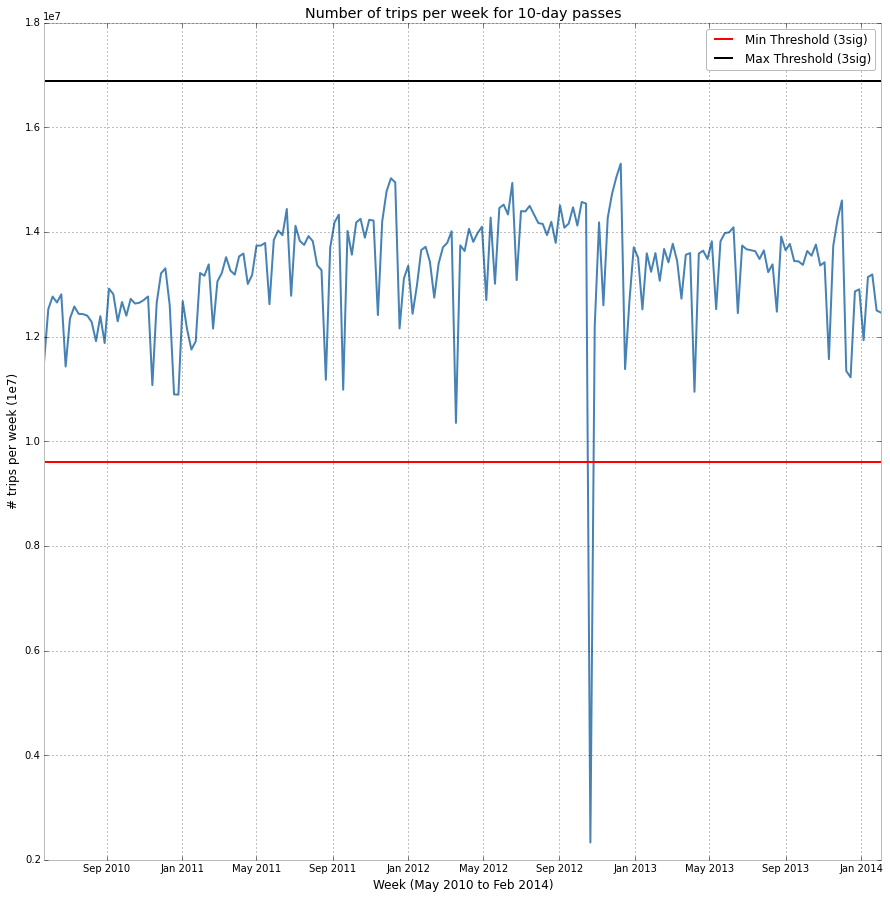

In [7]:
# Set the threshold: lowerbound and upper bound are 3* standard dev from
# the mean
mean10d = np.nanmean(mta_all10d)
std10d = np.nanstd(mta_all10d)
thresholds = (mean10d - std10d*3, mean10d + std10d*3)


# plot
fig = pl.figure(figsize=(15, 15))
pl.plot(myweeks, mta_all10d)
pl.plot([myweeks.min(), myweeks.max()], [
        thresholds[0], thresholds[0]], 'r', label='Min Threshold (3sig)')
pl.plot([myweeks.min(), myweeks.max()], [
        thresholds[1], thresholds[1]], 'k', label='Max Threshold (3sig)')
pl.title("Number of trips per week for 10-day passes")
pl.xlabel('Week (May 2010 to Feb 2014)')
pl.ylabel('# trips per week (1e7)')
pl.legend()

####We can clearly see a precipitous drop late in 2012. My guess is this represents the week of 10/29/2012 - when Hurricane Sandy hit NYC and the subway system was shut down for days.

####Let's include the other rider types (if it was Hurricane Sandy, it should impact all riders of course).

In [8]:
mta_total = np.nansum(mta_all, axis =0)

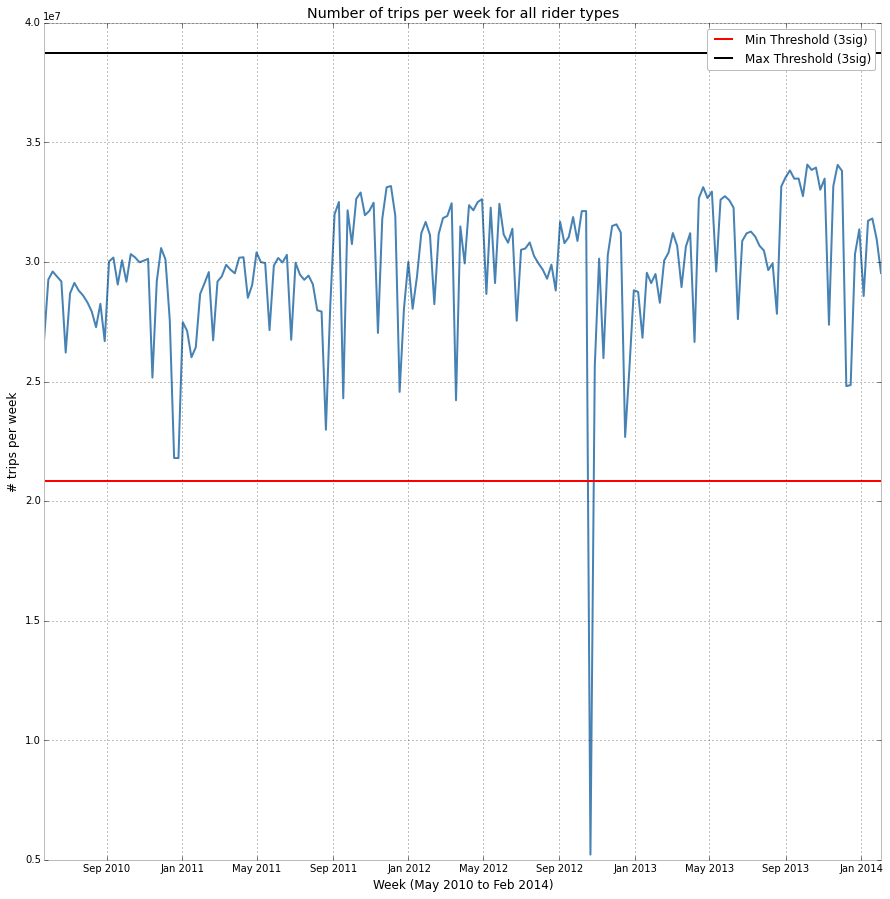

In [9]:
# Set the threshold
mean_all = np.nanmean(mta_total)
std_all = np.nanstd(mta_total)
all_thresholds = (mean_all - std_all*3, mean_all + std_all*3)


# plot
fig = pl.figure(figsize=(15, 15))
pl.plot(myweeks, mta_total)
pl.plot([myweeks.min(), myweeks.max()], [
        all_thresholds[0], all_thresholds[0]], 'r', label='Min Threshold (3sig)')
pl.plot([myweeks.min(), myweeks.max()], [
        all_thresholds[1], all_thresholds[1]], 'k', label='Max Threshold (3sig)')
pl.title("Number of trips per week for all rider types")
pl.xlabel('Week (May 2010 to Feb 2014)')
pl.ylabel('# trips per week')
pl.legend()

####When we add in all data (all riders and all stations), we indeed see the same event. This is very likely due to Hurricane Sandy's impact in late October/early November 2012.

A quick and dirty Google search finds news that corroborates our guess: 
http://www.nytimes.com/2012/10/31/nyregion/subways-may-be-shut-for-several-days-after-hurricane-sandy.html?_r=0


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

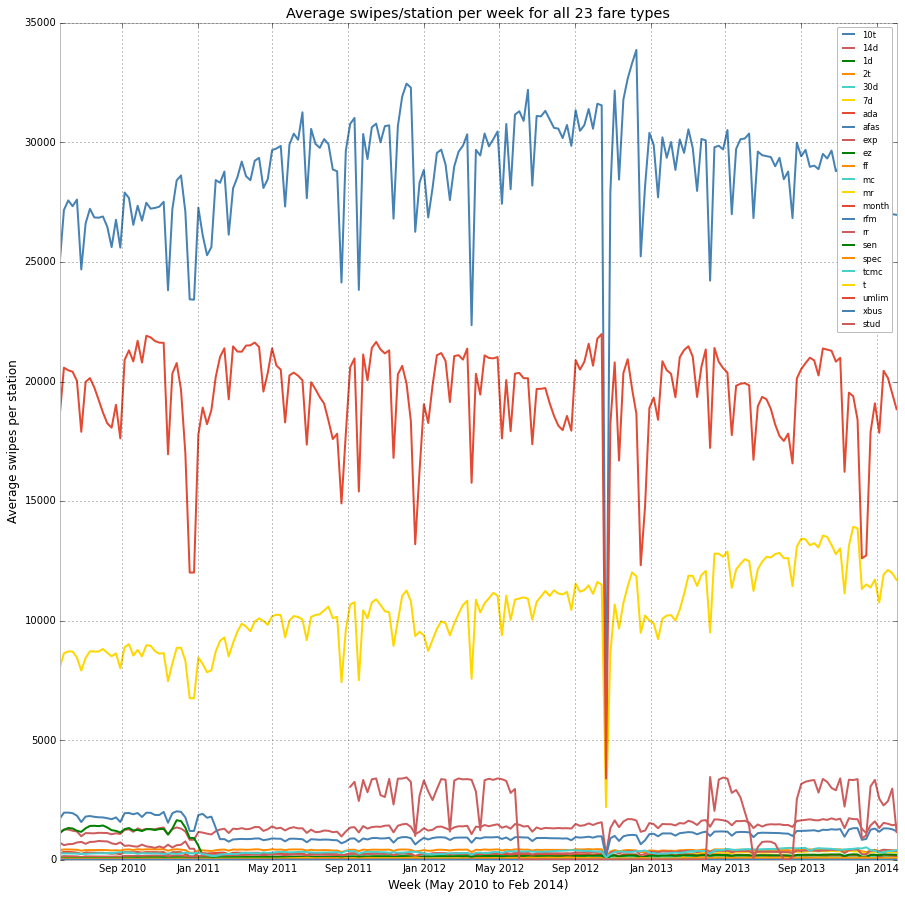

In [22]:
# Time series over 194 weeks of average swipes out of 600 stations for
# each rider type
mta2 = np.nanmean(mta, axis=0)

# list of riders
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
            'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
            'umlim', 'xbus', 'stud']

fig = pl.figure(figsize=(15, 15))
fontP = FontProperties()
fontP.set_size('small')
for i in range(0, len(mta2)):
    pl.plot(myweeks, mta2[i], label=ridetype[i])
    pl.legend(prop=fontP)
pl.title('Average swipes/station per week for all 23 fare types')
pl.xlabel('Week (May 2010 to Feb 2014)')
pl.ylabel('Average swipes per station')
pl.legend(prop=fontP)

####Structure
Looking at a plot of all 23 fare types, you can see some structure (a few types at the low swipe-count end that look to have dropped off in Jan 2011. Another (railroad?) that looks to have started in Sept 2011, dropped almost completely off in June/July 2012 and then came back to previous levels in May 2013.). 

####Trend up and down
Just as a visual estimate, the 7day pass (yellow) looks to have an upward trend. Other than the structure mentioned previously the rest of the types (particularly 10 trip and 14 day) seem to be stationary and at a glance - although the 10 trip could be an upward trend), nothing seems to be trending down (although again, a few groups look to have drop-offs around Jan 2011).

####We'll conduct a bit of analysis to confirm the visual trends if we can. First let's look at a graph smoothed out with a rolling mean.

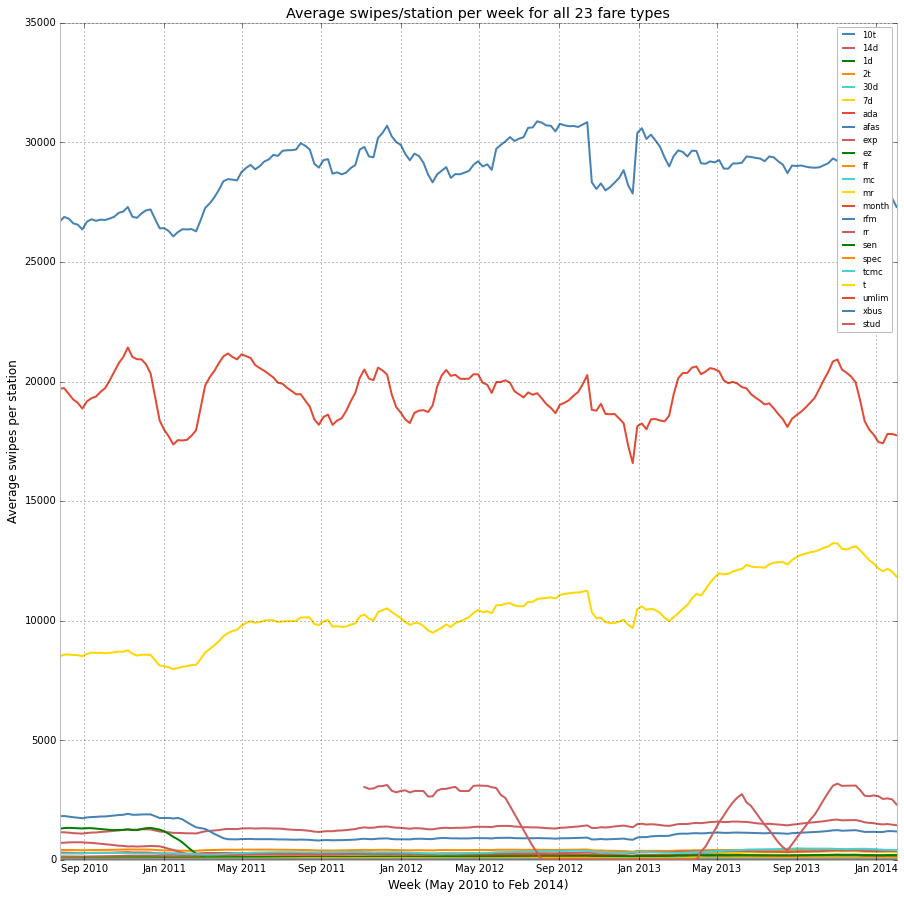

In [23]:
# convert 2D nparray to dataframe to perform pd.rolling_mean and plot for each of 23 groups
# we'll set the rolling mean window to 10
smoothFactor = 10

fig = pl.figure(figsize=(15, 15))
fontP = FontProperties()
fontP.set_size('small')
for i in range(0, len(mta2)):
    pl.plot(myweeks, pd.rolling_mean(
        pd.DataFrame(mta2[i]), smoothFactor), label=ridetype[i])
    pl.legend(prop=fontP)
pl.title('Average swipes/station per week for all 23 fare types')
pl.xlabel('Week (May 2010 to Feb 2014)')
pl.ylabel('Average swipes per station')
pl.legend(prop=fontP)

####Smoothing at a window of  10 weeks let's us do a few things:
####Structure: 
We re-affirm that there is some structure (a dip) happening with low-swipe types (possibly correlated) around Jan 2011 and with the (railroad?) type for the last half of 2012/first half 2013.
####Upward trend: 
We also see a trend up for 7 day trips. (FYI with a rolling mean window of 20+, 10-trip passes also appear to trend upward).
####Downward trend:
With noise dampened we also see what might be a downward trend for 14 day passes.

####We'll do a quick and simple calculation of a ratio of usage in the last 10 over the first 10 weeks to identify any trends. There are a few different ways to do this. We'll compare the % of usage by fare type for the last 10 wk period compared with the first 10 week period and see if there has been any increase/decrease in any fares' ratio of usage compared to all types.

In [12]:
# convert to pandas Series and find ratio of swipes per fare type/all fare
# types for last and first 10 week periods
trends = pd.DataFrame(index=ridetype)
trends['last'] = pd.DataFrame([np.nansum(
    mta2[x][-10:])/np.nansum(mta2[:][-10:]) for x in range(0, len(mta2))], index=ridetype)
trends['first'] = pd.DataFrame([np.nansum(
    mta2[x][:10])/np.nansum(mta2[:][:10]) for x in range(0, len(mta2))], index=ridetype)
trends['diff'] = trends['last'] - trends['first']

In [26]:
print ('Ratio of fare type in LAST 10 week period, FIRST 10 week period, and\n'
       'the DIFF between last and first.\n'
      'Then ranked on the value of the difference (i.e. increase/decrease):')
print trends.sort('diff')

Ratio of fare type in LAST 10 week period, FIRST 10 week period, and
the DIFF between last and first.
Then ranked on the value of the difference (i.e. increase/decrease):
               last         first      diff
ez     3.015598e-08  1.097095e-03 -0.001097
exp    1.172927e-07  5.996002e-04 -0.000599
afas   7.708472e-08  2.010613e-05 -0.000020
xbus   2.653347e-05  8.718376e-07  0.000026
umlim  1.796802e-04  1.213184e-05  0.000168
t      7.235163e-04  3.869016e-05  0.000685
ff     1.132267e-03  7.553446e-05  0.001057
spec   1.067905e-03  8.308025e-07  0.001067
30d    1.661668e-03  8.781607e-05  0.001574
1d     1.858728e-03  9.136063e-05  0.001767
month  2.663304e-03  2.513821e-04  0.002412
sen    3.043382e-03  5.713963e-05  0.002986
mr     4.818253e-03  1.061311e-08  0.004818
mc     5.364777e-03  2.414799e-04  0.005123
rr     5.607333e-03  1.181241e-04  0.005489
2t     5.966392e-03  3.490253e-04  0.005617
tcmc   6.206990e-03  2.212898e-04  0.005986
rfm    1.837737e-02  1.545368e-03  0.

####Just looking at the change in % of fare type for the last 10 wks vs the first, we see 3 (ez, exp, and afas) as having a negative direction and the rest having postive trends; however, only the 7d, ada, and 10t fare types seem to have nontrivial differences either way (absolute value of difference is at least an order of magnitude greater than the rest of the deltas). 

####10-trip fares have the largest difference, which was a little harder to percieve in even the smoothed plot. Although the 7day also had a noticeable upward trend as was visible in the plot. 

####It is worth noting that this difference in ratios reflects only the "edges" of the data and can be easily influenced by local spikes.

#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

####We'll plot all the stations' swipes first.

In [17]:
# sum of all rides
mta3 = pd.DataFrame(np.transpose(np.nansum(mta, axis=1)))

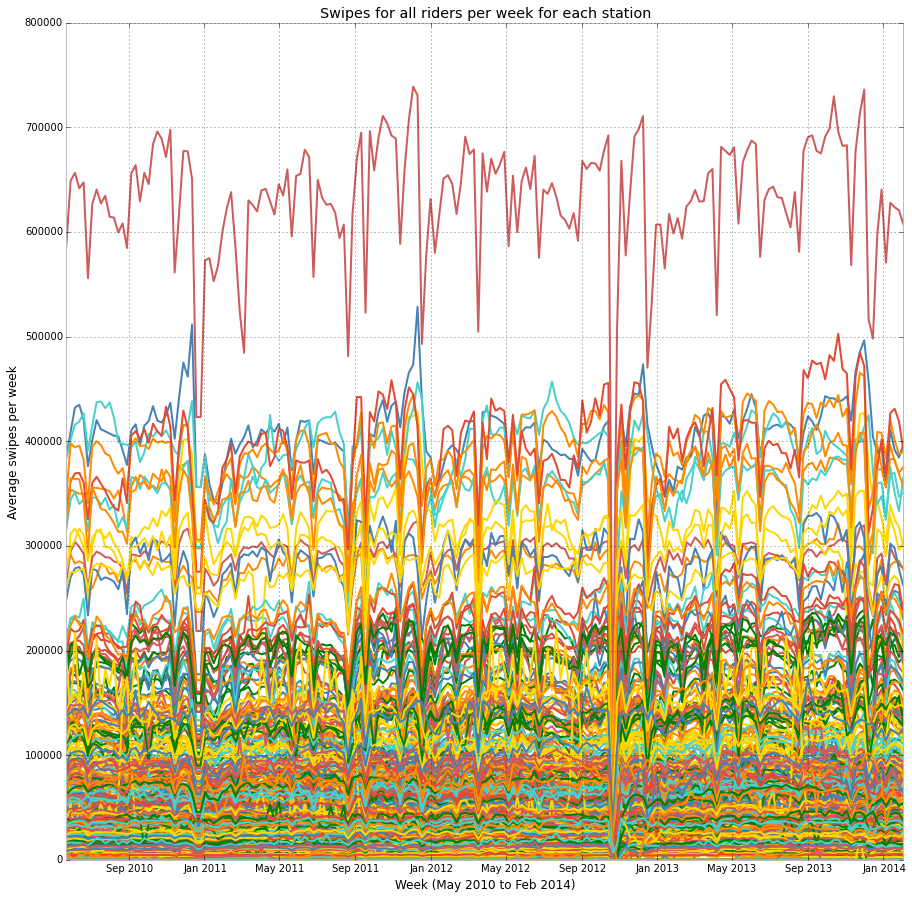

In [18]:
N = len(mta)
fig = pl.figure(figsize=(15,15))
for i in range(0,N):
    pl.plot(myweeks, mta3[i])
pl.title('Swipes for all riders per week for each station')
pl.xlabel('Week (May 2010 to Feb 2014)')
pl.ylabel('Average swipes per week')

#### Not surpisingly, for hundreds of stations, this graph is a bit of a mess, but we can at least see that the data seems intact, such as Hurricane Sandy being clearly visible.

####Now we'll do a Fourier Transform to find which stations have strong periodicity.

(0.0, 0.5, 0, 3500000)

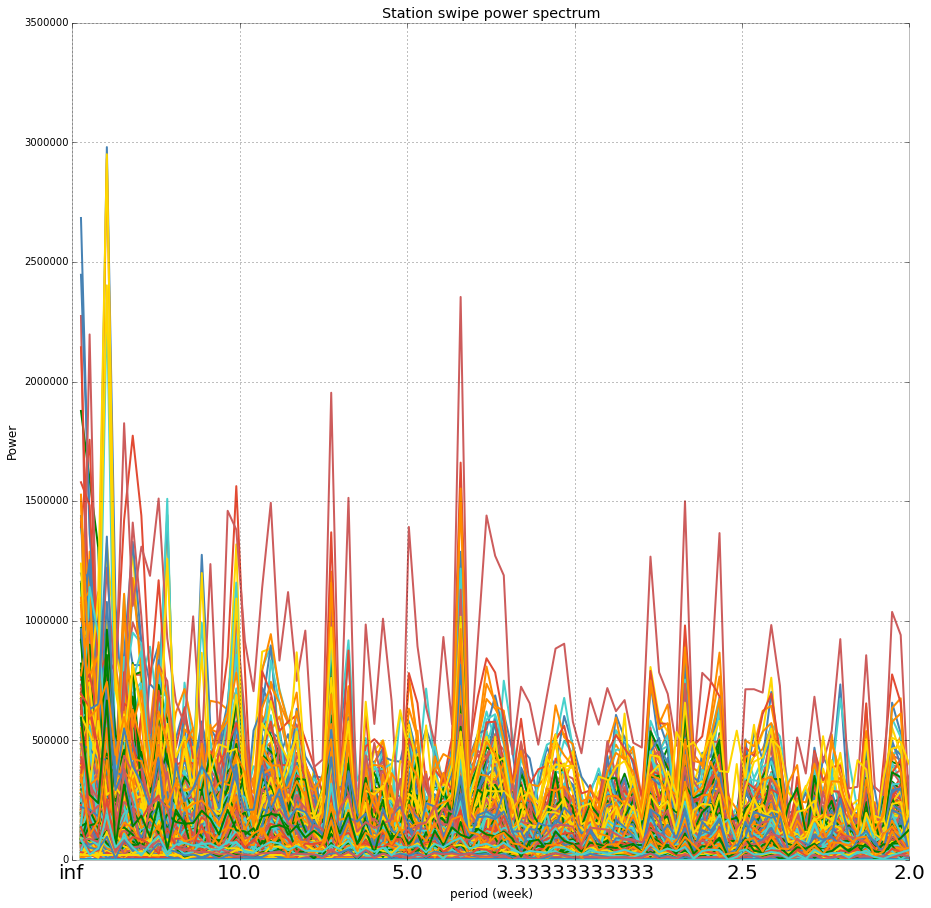

In [28]:
# plot periodicity
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
for i in range(0, N):
    f = np.abs(np.fft.rfft(mta3[i]))
    # we'll create a plot for each station
    # note with the [1:] nudge, we're bumping an outlier
    # setting the sample spacing to 1 (1 week)
    ax.plot(np.fft.rfftfreq(len(mta3), 1.0)[1:], (f[1:]))
ax.set_xticklabels(["%s" % (1./f) for f in ax.get_xticks()], fontsize=20)
pl.title('Station swipe power spectrum')
pl.xlabel('period (week)')
pl.ylabel('Power')
# we'll zoom in a bit
pl.axis(ymin=0, ymax=3500000)

#### We see a few stations with spikes in power for periodicity, around 4 weeks, around 6-7 weeks, and then higher - perhaps at 52 weeks (1 yr), although it's a bit difficult to discern from this graph.

####Looking at the largest Fourier transform numbers, we'll find the stations with the most power.

In [20]:
# put FT numbers in a list
f_list = []
for i in range(0, N):
    f = np.abs(np.fft.rfft(mta3[i]))
    f_list.append(f)

# find the top value for each station
max_power = []
for i in range(0, N):
    max_power.append(f_list[i].max())

# list the index of the top 4 stations accoding to power
sorted(range(len(max_power)), key=lambda i: max_power[i])[-4:]

[83, 45, 21, 169]

### TOP 4: It's impossible to say what exact stations these are, but those with index 83, 45, 21, 169 seem to have the most powerful periodicity, respectively. Does a plot bear this out?


(0.0, 0.5, 0, 3500000)

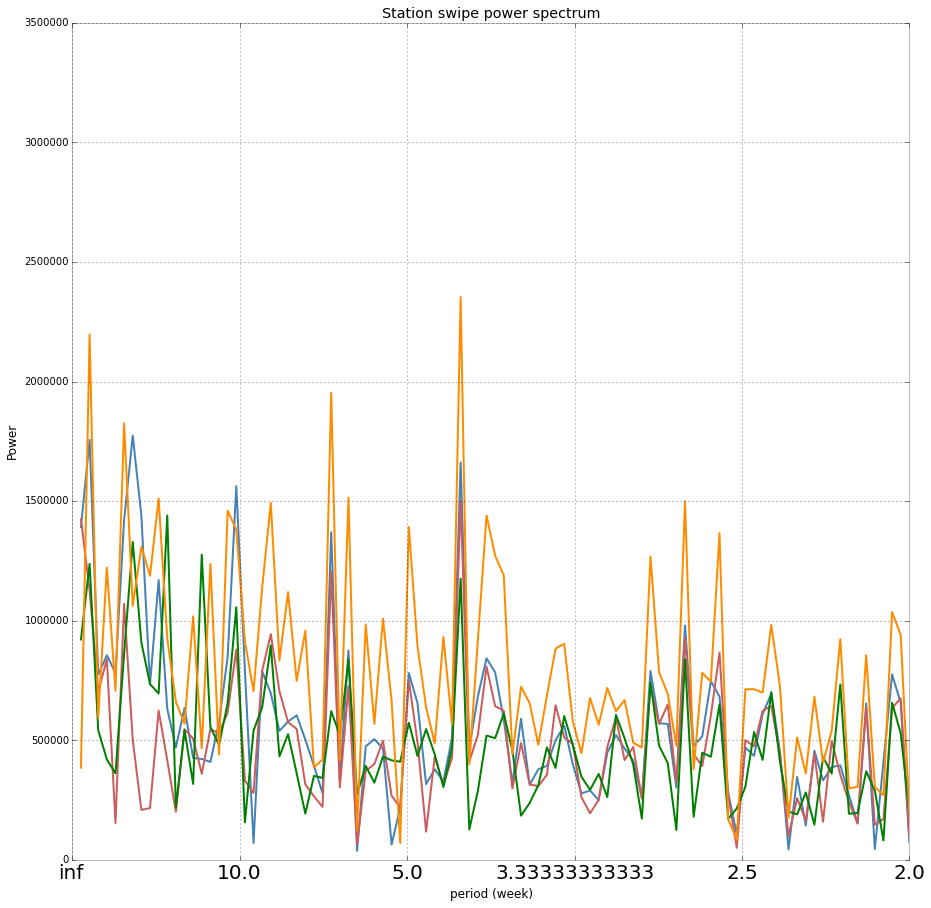

In [34]:
# plot top 4 stations
top4 = [83, 45, 21, 169]
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
for i in top4:
    f = np.abs(np.fft.rfft(mta3[i]))
    # we'll create a plot for each station
    # note with the [1:] nudge, we're bumping an outlier
    # setting the sample spacing to 1 (1 week)
    ax.plot(np.fft.rfftfreq(len(mta3), 1.0)[1:], (f[1:]))
ax.set_xticklabels(["%s" % (1./f) for f in ax.get_xticks()], fontsize=20)
pl.title('Station swipe power spectrum')
pl.xlabel('period (week)')
pl.ylabel('Power')
# we'll zoom in a bit
pl.axis(ymin=0, ymax=3500000)

#### Kind of difficult to tell if these are the top compared to others not plotted, but they do all see to share powerful periodicity around similar weekly cycles (4 weeks is the strongest,6-7, and maybe 52).

####Notably, however, the power in the left range (52 weeks) seems to be missing some data points. The previous graph showed some stations with a power of nearly 3000000 whereas they are absent in this graph. It is likely due to misreading or mis-organizing the Fourier Transform numbers. 

####I can only speculate what a cause might be. Perhaps for stations on an annual cycle, they are seasonal, like the stations by the Rockaways that provide access to beaches -- they may experience a 52-week cycle (high in summer, low in winter). Another possibility might be the station near Flushing Meadows where the U.S. Open is (although  it is the same station used for CitiField, so baseball season would likely influence the pattern.



# END OF DJC WORK
#
#
#

#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [5]:
#after reading the datacube you should see:
mta.shape


(600, 23, 194)

ride types list

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

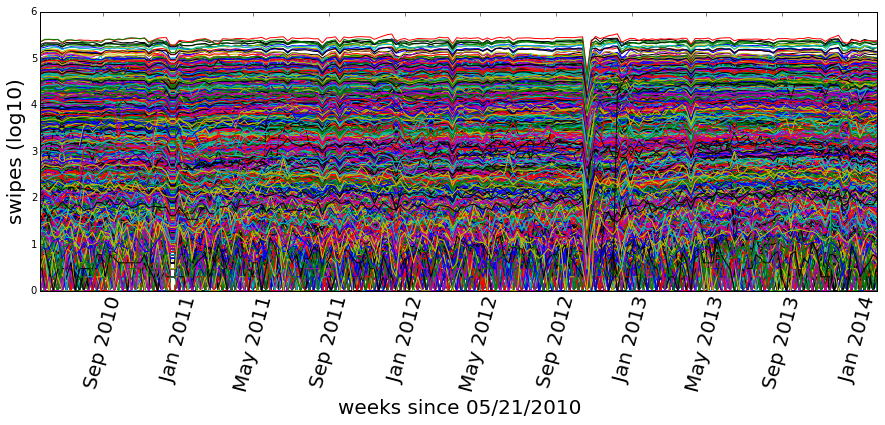

In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mta.shape)
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mta, axis=1)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)


##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


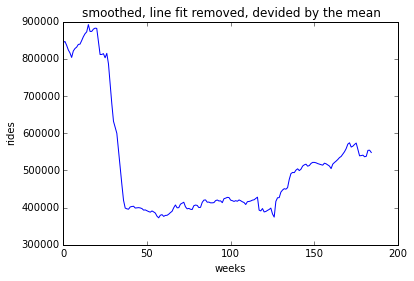

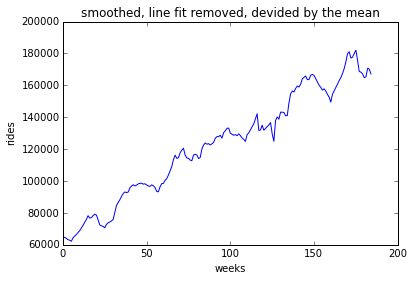

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

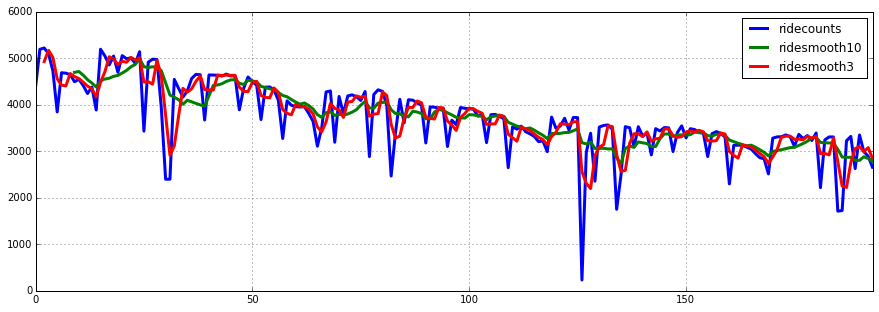

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

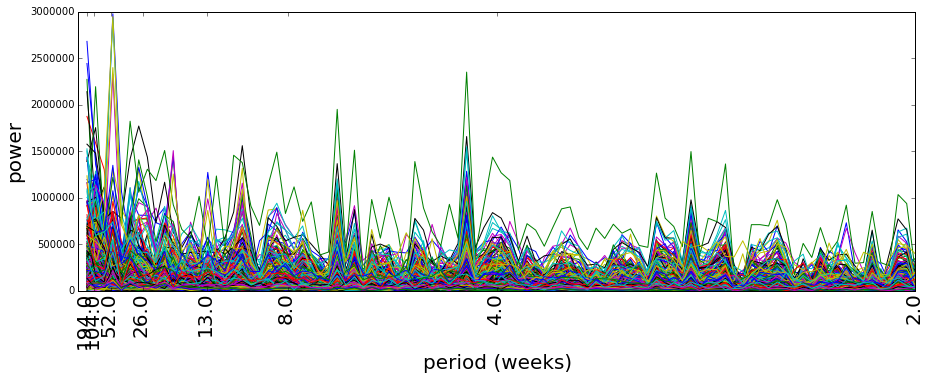

In [51]:
#this is a "power spectrum": the plot of the absolute value of the fourier transform. 
#I changed the xtick labels from frequecy (1/week) to period (in weeks)
#to facilitate the visual identification of the 1-year period peak
#(notice however that np.fft.rfftfreq(N, d)  returns frequency)

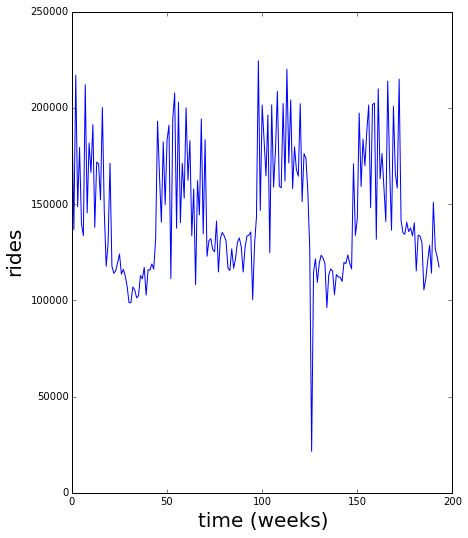

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space